In [1]:
import tensorflow as tf
import tensorflow_hub as hub
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import cv2
from urllib import request
# Some modules to display an animation using imageio.
import imageio
from IPython import display
#from riptide.data.UCF101.dataset import *

/opt/conda/envs/riptide-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def parse_text(line):
    out = tf.string_split([line], delimiter=" ").values
    filename, label = out[0], out[1]
    label = tf.string_to_number(label, tf.int32)
    return filename, label

In [3]:
# Utilities to open video files using CV2
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, label, max_frames=0, resize=(224, 224)):
    path = "/data/UCF-101/"+path.decode()
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames, dtype=np.float32) / 255.0, label

In [4]:
def animate(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    with open('./animation.gif','rb') as f:
        display.display(display.Image(data=f.read(), height=300))

In [11]:
def get_ds():
    files = ["/data/ucfTrainTestlist/test_map.txt"]
    #ds = files.apply(tf.contrib.data.parallel_interleave(tf.data.TextLineDataset, cycle_length=4))
    ds = tf.data.TextLineDataset(files)
    #ds = ds.shuffle(buffer_size=50000)
    ds = ds.map(parse_text)
    ds = ds.map(
    lambda filename, label: tuple(tf.py_func(
        load_video, [filename, label], [tf.float32, label.dtype])))
    return ds

In [12]:
ds = get_ds()

In [13]:
iter(ds).next()

(<tf.Tensor: id=72, shape=(164, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.24705882, 0.25490198, 0.31764707],
          [0.24705882, 0.25490198, 0.31764707],
          [0.24313726, 0.2509804 , 0.3137255 ],
          ...,
          [0.92941177, 0.7607843 , 0.80784315],
          [0.92941177, 0.7607843 , 0.8       ],
          [0.92941177, 0.7607843 , 0.8       ]],
 
         [[0.24705882, 0.25490198, 0.31764707],
          [0.24705882, 0.25490198, 0.31764707],
          [0.24313726, 0.2509804 , 0.3137255 ],
          ...,
          [0.92941177, 0.7607843 , 0.80784315],
          [0.92941177, 0.7607843 , 0.8       ],
          [0.92941177, 0.7607843 , 0.8       ]],
 
         [[0.24705882, 0.25490198, 0.31764707],
          [0.24705882, 0.25490198, 0.31764707],
          [0.24313726, 0.2509804 , 0.3137255 ],
          ...,
          [0.92941177, 0.7607843 , 0.80784315],
          [0.92941177, 0.7607843 , 0.8       ],
          [0.92941177, 0.7607843 , 0.8       ]],
 
         ...,


In [8]:
with tf.Graph().as_default():
    ds = get_ds()
    train_iter = tf.data.Iterator.from_structure(ds.output_types, ds.output_shapes)
    train_init_op = train_iter.make_initializer(ds)
    features, l = train_iter.get_next()
    model_input = tf.expand_dims(features, 0)
    
    i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
    input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
    logits = i3d(input_placeholder)
    probabilities = tf.nn.softmax(logits)
    with tf.train.MonitoredSession() as sess:
        sess.run(train_init_op)
        elem = sess.run(model_input)        
        [ps] = sess.run(probabilities, feed_dict={input_placeholder: elem})

In [12]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
    labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [13]:
print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
    print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
swimming breast stroke 94.21%
swimming butterfly stroke 5.31%
catching fish          0.23%
surfing water          0.05%
swimming backstroke    0.03%


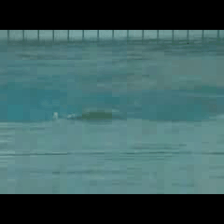

In [14]:
animate(elem[0])